In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen import get_simu_data
from models.gan_v4 import Generator, Discriminator
from gan.gan_train2 import MyGAN2
from gan.utils import MyDataSet
from demo_settings import simu_settings
from CQR import get_CQR_CIs

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

# Params

In [5]:
setting = "setting1"

'setting1'

In [6]:
params = edict()

params.simu_setting = edict()
params.simu_setting.rho = 0.9
params.simu_setting.is_homo = False
params.simu_setting.n = 1000
params.simu_setting.d = 100
params.simu_setting.ntest = 1000
params.simu_setting.cal_ratio = 0.25
params.simu_setting.update(simu_settings[setting])
pprint(params.simu_setting)


params.nrep = 100 # num of reptition for simulation
params.K = 40 # num of sps drawn from q(Y(1)|X)
params.nz = 5 # the dim of features for GAN
params.save_snapshot = 100

params.gan_training = edict()
# Batch size during training
params.gan_training.batch_size = 32
# Number of training epochs
params.gan_training.num_epochs = 1000
# Learning rate for optimizers
params.gan_training.lr = 0.002
# Beta1 hyperparameter for Adam optimizers
params.gan_training.beta1 = 0.5
params.gan_training.device="cpu"

params.wconformal = edict()
# remove too large and too small in ws/mean(ws)
params.wconformal.nwthigh = 20
params.wconformal.nwtlow = 0.05
params.wconformal.useinf = False


params.hypo_test = edict()
params.hypo_test.alpha = 0.05 # sig level

params.prefix = ""
params.save_dir = f"demo_{setting}_test"
if not (RES_ROOT/params.save_dir).exists():
    (RES_ROOT/params.save_dir).mkdir()

{'cal_ratio': 0.25,
 'd': 10,
 'is_homo': True,
 'n': 1000,
 'ntest': 1000,
 'rho': 0}


# Some fns

In [7]:
def _gen_Y_given_X(X, netG):
    """With generative model f(Y|X), generate Y given X
    """
    if X.ndim == 1:
        X = X.reshape(1, -1)
    X_mul = torch.tensor(X * np.ones((params.K, 1)));
    Zs = torch.randn(params.K, params.nz);
    with torch.no_grad():
        _, Yhat = netG(X_mul, Zs)
        Yhat = Yhat.view(-1).numpy()
        #Yhat = netG(X_mul, Zs).view(-1).numpy() #!!!!
    return Yhat

def _get_pred_intv(X, qv, netG):
    teY_hat = _gen_Y_given_X(X, netG);
    intvs = np.stack([teY_hat-qv, teY_hat+qv]).T
    return merge_intervals(intvs)

def _get_metric(v, intvs):
    if not isinstance(v, np.ndarray):
        v = np.array(v)
    in_sets = np.sum([np.bitwise_and(v>intv[0], v<intv[1]) for intv in intvs], axis=0)
    intvs_len = np.sum([np.diff(intv) for intv in intvs])
    metrics = edict()
    metrics.in_sets = in_sets
    metrics.intvs_len = intvs_len
    return metrics

# Simu

<All keys matched successfully>

In [59]:
def _run_fn(rep_ix):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    torch.set_default_dtype(torch.float64)
    torch.set_default_tensor_type(torch.DoubleTensor)

    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    n_train = int(data_train.T.sum()*(1-params.simu_setting.cal_ratio));
    tr_idxs = np.sort(np.random.choice(np.where(data_train.T)[0], size=n_train, replace=False));
    cal_idxs = np.setdiff1d(np.where(data_train.T)[0], tr_idxs);
    
    
    # train q(Y(1)|X)
    # I skip this for now, suppose you get one
    data_train_gan = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    input_params = params.gan_training.copy()
    input_params.pop("num_epochs")
    #my_gan =  MyGAN2(Generator=Generator, Discriminator=Discriminator, nz=params.nz,
    #                d=params.simu_setting.d, train_data=data_train_gan, save_dir=params.save_dir, verbose=False,
    #                prefix=f"rep{rep_ix}",
    #                **input_params);
    #my_gan.train(num_epochs=params.gan_training.num_epochs, data_test=None, save_snapshot=params.save_snapshot)
    #netG = my_gan.netG;
    netG = Generator(nz=params.nz, d= params.simu_setting.d);
    netG.load_state_dict(torch.load(RES_ROOT/"demo_setting1_test/rep2_gan_G_epoch1000_iter10000.pth"))
    netG.eval();
    
    
    # propensity score
    # I can use all data in train set (including cal set)
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0)
    psY = data_train.T.astype(int)
    psX = data_train.X
    clf = clf.fit(psX, psY);
    def psfun(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return clf.predict_proba(x)[:, 1]
    
    
    # weight function
    def wtfun(x):
        # for unconditional weight
        return 1/psfun(x)
    
    
    # get the weight and nonconformity score for each data point in cal set
    wE_set = []
    for cal_idx in cal_idxs:
        cal_X = data_train.X[cal_idx]
        cal_Y = data_train.Y1[cal_idx]
        w = wtfun(cal_X)
        
        # draw K sps from q(Y|X)
        Yhat = _gen_Y_given_X(cal_X, netG)
            
        # the nonconformity score
        E = np.abs(Yhat - cal_Y).min()
        
        wE_set.append([w[0], E])
    ws = np.array(wE_set)[:, 0]
    Es = np.array(wE_set)[:, 1];
    
    
    # evaluate on test data
    
    test_res = []
    for te_idx in range(params.simu_setting.ntest):
        teX = data_test.X[te_idx]
        teY1 = data_test.Y1[te_idx]
        tetau = data_test.tau[te_idx]
        
        # get qv for current test pt
        ws_wtest = np.concatenate([ws, wtfun(teX)]);
        Es_winf = np.concatenate([Es, [np.inf]]);
        nws_wtest = ws_wtest/ws_wtest.mean();
        nws_wtest[nws_wtest<params.wconformal.nwtlow] = params.wconformal.nwtlow
        nws_wtest[nws_wtest>params.wconformal.nwthigh] = params.wconformal.nwthigh
        # can not take the inf into consider
        #qv_cur = weighted_quantile(Es_winf, [1-params.hypo_test.alpha], sample_weight=nws_wtest);
        qt = (1 + nws_wtest[-1]/ nws_wtest[:-1].sum()) * (1 - params.hypo_test.alpha)
        if qt <= 1:
            qv_cur = weighted_quantile(Es, [qt], sample_weight=ws_wtest[:-1]);
        else:
            if params.wconformal.useinf:
                qv_cur = np.inf
            else:
                qv_cur = np.max(Es)
        
        intvs = _get_pred_intv(teX, qv_cur, netG)
        test_res.append(_get_metric([teY1, tetau], intvs))
    prbs = np.mean([res['in_sets'] for res in test_res], axis=0)
    mlen = np.mean([res['intvs_len'] for res in test_res])
    
    
    # results from CQR
    CQR_CIs = get_CQR_CIs(X=data_train.X, Y=data_train.Y, 
                          T=data_train.T, Xtest=data_test.X, 
                          nav=0, 
                          alpha=params.hypo_test.alpha, 
                          fyx_est="quantBoosting", seed=manualSeed)
    mlen_cqr = np.mean(CQR_CIs[:, 1] -  CQR_CIs[:, 0])
    prb_Y1_cqr = np.bitwise_and(data_test.Y1>CQR_CIs[:, 0], data_test.Y1<CQR_CIs[:, 1]).mean()
    prb_tau_cqr = np.bitwise_and(data_test.tau>CQR_CIs[:, 0], data_test.tau<CQR_CIs[:, 1]).mean()
    
    res_all = edict()
    res_all.GAN = (prbs, mlen)
    res_all.CQR = ([prb_Y1_cqr, prb_tau_cqr], mlen_cqr)
    return res_all

In [60]:
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn)(rep_ix) for rep_ix in tqdm(range(params.nrep), total=params.nrep))

save_pkl((RES_ROOT/params.save_dir)/f"res_demo1.pkl", test_ress, is_force=True)

 20%|███████████████████████████▍                                                                                                             | 20/100 [00:00<00:01, 74.67it/s]R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to console]: Loading required namespace: gbm

R[write to cons

Save to /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_setting1_test/res_demo1.pkl


In [61]:
test_ress = load_pkl(RES_ROOT/params.save_dir/f"res_demo1.pkl")
ITE_prbs = ddict(list)
CATE_prbs = ddict(list)
lens = ddict(list)
keys = test_ress[0].keys()
for res in test_ress:
    for ky, v in res.items():
        ITE_prbs[ky].append(v[0][0])
        CATE_prbs[ky].append(v[0][1])
        lens[ky].append(v[1])

Load file /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_setting1_test/res_demo1.pkl


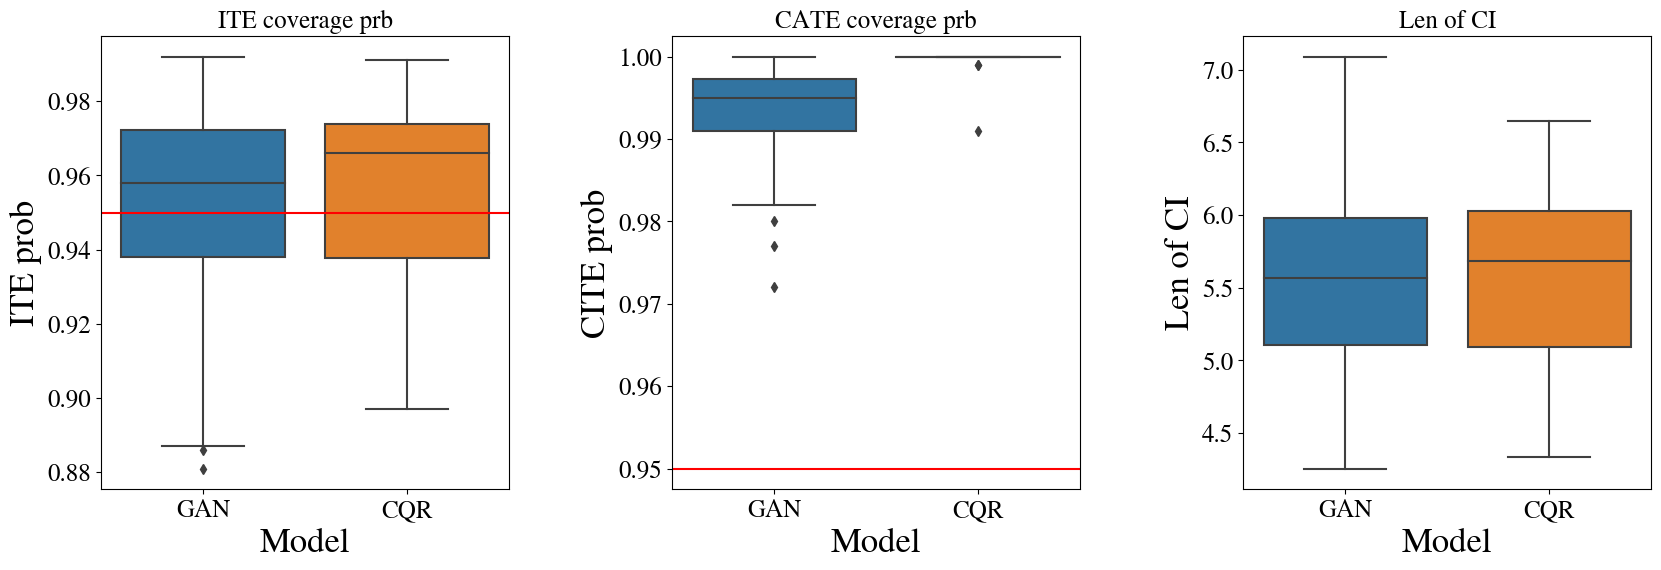

In [62]:
plt.figure(figsize=[20, 6])
plt.subplot(131)
plt.title("ITE coverage prb")
df = pd.DataFrame(ITE_prbs);
df1 = df.melt(var_name='Model', value_name='ITE prob')
sns.boxplot(data=df1, y="ITE prob", x="Model")
plt.axhline(y=0.95, color="red");

plt.subplot(132)
plt.title("CATE coverage prb")
df = pd.DataFrame(CATE_prbs);
df1 = df.melt(var_name='Model', value_name='CITE prob')
sns.boxplot(data=df1, y="CITE prob", x="Model")
plt.axhline(y=0.95, color="red");

plt.subplot(133)
plt.title("Len of CI")
df = pd.DataFrame(lens);
df1 = df.melt(var_name='Model', value_name='Len of CI')
sns.boxplot(data=df1, y="Len of CI", x="Model", showfliers=False);

# Compare results

In [21]:
test_ress1 = load_pkl(RES_ROOT/"demo_setting10/res_demo.pkl")
test_ress2 = load_pkl(RES_ROOT/"demo_setting1_test/res_demo.pkl")
ITE_prbs = ddict(list)
CATE_prbs = ddict(list)
lens = ddict(list)
for res in test_ress1:
    for ky, v in res.items():
        if ky == "GAN":
            nky = ky
        else:
            nky = ky
        ITE_prbs[nky].append(v[0][0])
        CATE_prbs[nky].append(v[0][1])
        lens[nky].append(v[1])
for res in test_ress2:
    for ky, v in res.items():
        if ky == "CQR":
            continue
        nky = ky+"-fixed"
        ITE_prbs[nky].append(v[0][0])
        CATE_prbs[nky].append(v[0][1])
        lens[nky].append(v[1])

Load file /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_setting10/res_demo.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_setting1_test/res_demo.pkl


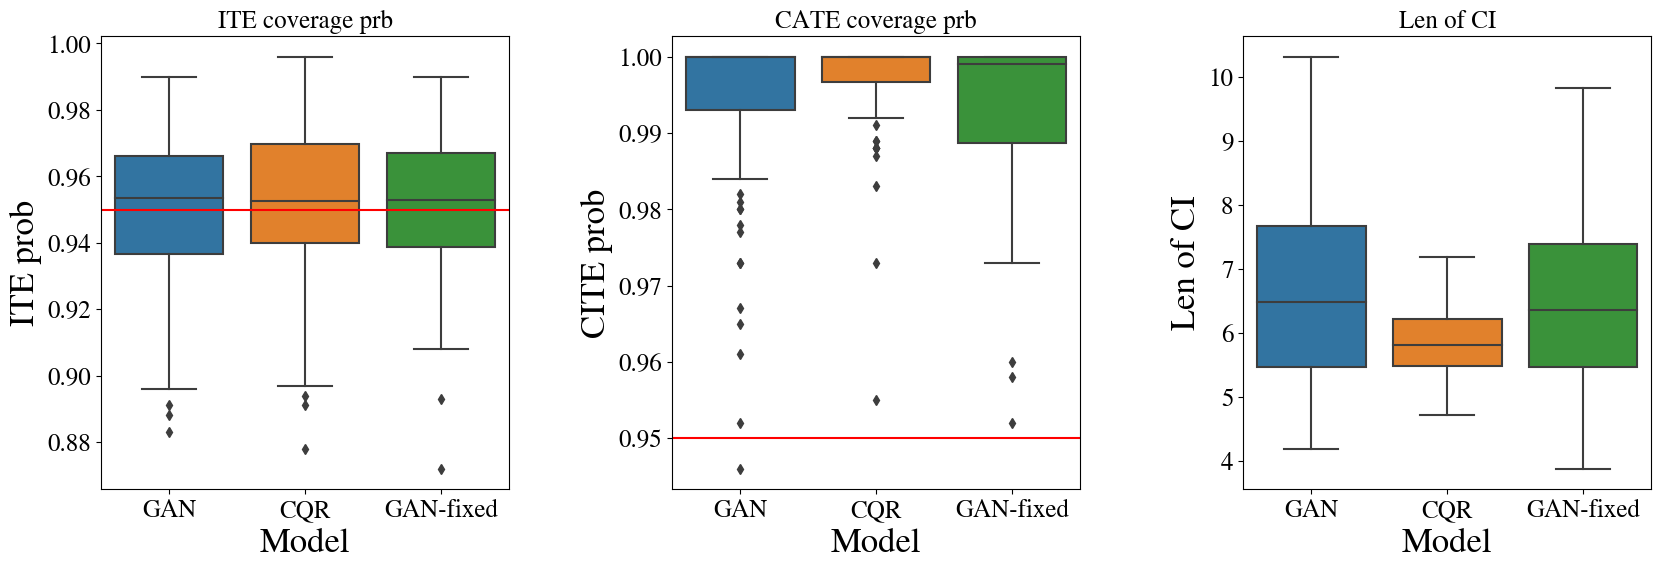

In [22]:
plt.figure(figsize=[20, 6])
plt.subplot(131)
plt.title("ITE coverage prb")
df = pd.DataFrame(ITE_prbs);
df1 = df.melt(var_name='Model', value_name='ITE prob')
sns.boxplot(data=df1, y="ITE prob", x="Model")
plt.axhline(y=0.95, color="red");

plt.subplot(132)
plt.title("CATE coverage prb")
df = pd.DataFrame(CATE_prbs);
df1 = df.melt(var_name='Model', value_name='CITE prob')
sns.boxplot(data=df1, y="CITE prob", x="Model")
plt.axhline(y=0.95, color="red");

plt.subplot(133)
plt.title("Len of CI")
df = pd.DataFrame(lens);
df1 = df.melt(var_name='Model', value_name='Len of CI')
sns.boxplot(data=df1, y="Len of CI", x="Model", showfliers=False);